# Forecasting the cost of cars

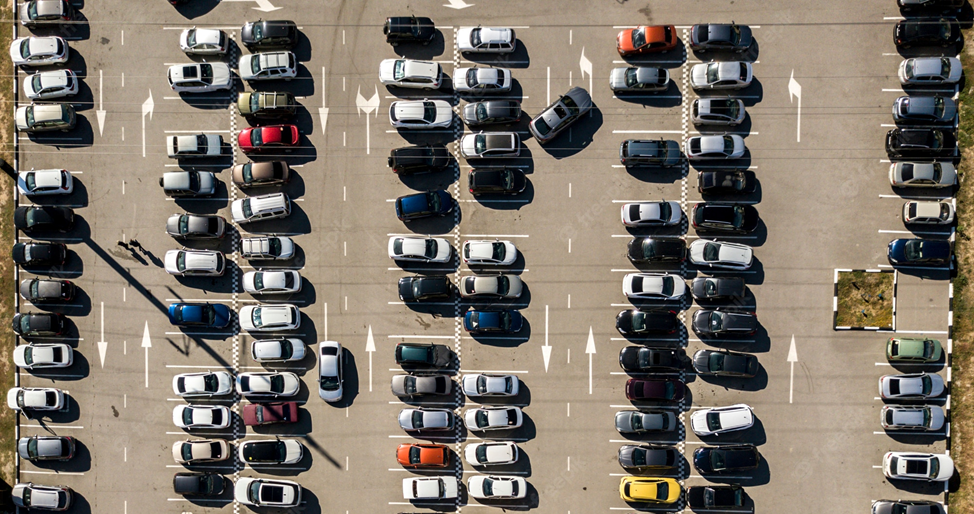

A used car service is developing an app to attract new customers. In it, you can quickly find out the market value of your car. Based on historical data (technical characteristics, equipment and prices of cars), you need to build a model to determine the cost of the car.

Key characteristics of the model:

\- quality of prediction;  
\- prediction speed;  
\- studying time.

**Task of the project:**

Develop a system for predicting the cost of cars based on historical data.

**Objective of the project:**

Build a model with an minimum RMSE-measure.


## Подготовка данных

### Загрузка и просмотр данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm
import matplotlib.pyplot as plt
import xgboost as xgb
import catboost as cat

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from catboost.utils import eval_metric
from catboost import CatBoostRegressor, cv, Pool, CatBoost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

sns.set(color_codes=True)
pd.options.mode.chained_assignment = None  

In [2]:
automobile_data = pd.read_csv(r'C:\\Users\\Vadim\\Documents\\Datasets\\autos.csv')

In [3]:
automobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
automobile_data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
automobile_data.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [6]:
automobile_data.duplicated().value_counts()

False    354365
True          4
dtype: int64

In [7]:
automobile_data = automobile_data.drop_duplicates()

In [8]:
def data_distribution(tab):
    for column in tab:
        if tab[column].dtype == 'int64' or tab[column].dtype == 'float64': 
            display(_=sns.catplot(y=column, kind='violin', data=tab))        

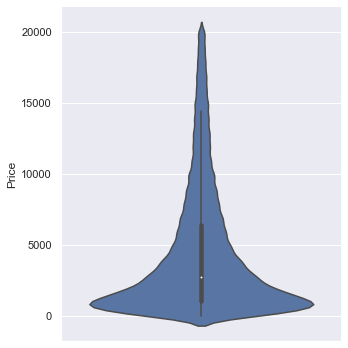

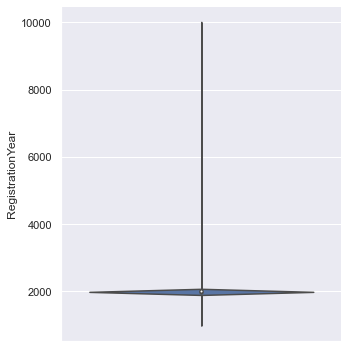

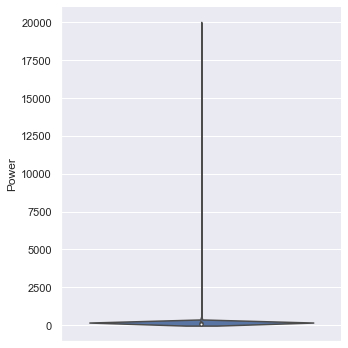

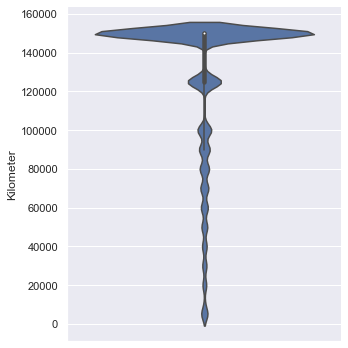

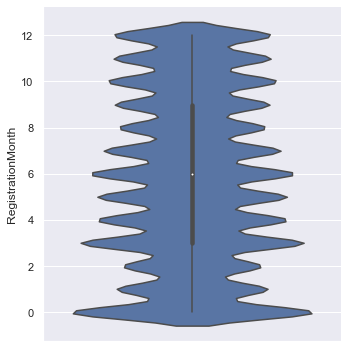

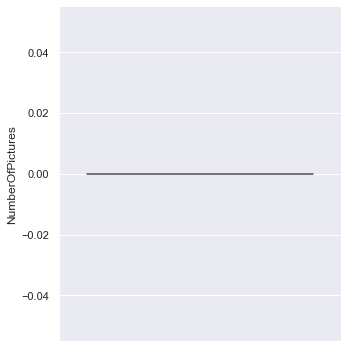

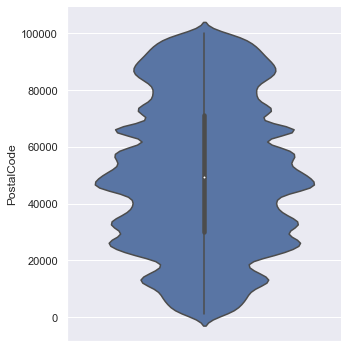

In [9]:
data_distribution(automobile_data)

In [10]:
automobile_data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
RegistrationYear,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
Kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
RegistrationMonth,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


In [11]:
def isna_style(x):
    mis_val = x.isnull().sum()
    mis_val_percent = (100 * x.isnull().sum() / len(x)).round(1)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'count_nan', 1 : '%_nan'})
    return mis_val_table_ren_columns.style.background_gradient('cool')

In [12]:
display(isna_style(automobile_data))

,count_nan,%_nan
DateCrawled,0,0.000000
Price,0,0.000000
VehicleType,37490,10.600000
RegistrationYear,0,0.000000
Gearbox,19833,5.600000
Power,0,0.000000
Model,19705,5.600000
Kilometer,0,0.000000
RegistrationMonth,0,0.000000
FuelType,32895,9.300000


In [13]:
for column in automobile_data:
    if automobile_data[column].dtype=='object':
        print({automobile_data[column].name : automobile_data[column].sort_values().unique()})
        print('_' * 100)

{'DateCrawled': array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'], dtype=object)}
____________________________________________________________________________________________________
{'VehicleType': array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)}
____________________________________________________________________________________________________
{'Gearbox': array(['auto', 'manual', nan], dtype=object)}
____________________________________________________________________________________________________
{'Model': array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'ag

**Conclusion:**

- Data uploaded successfully.
- Passes. The gaps are up to 20%, which is quite significant. In order not to distort the operation of the models, it will be necessary to process such columns.
- Data types. The dataset has an object type (text or mixed numeric and non-numeric values) and an int64 numeric data type. The object data type can store various types of data; in the future, for the convenience of work, it will be necessary to process it.
- Not many obvious duplicates were found - only 4 copies. They've been removed.
- No anomalies in the data distribution were found.
- Dependencies. No linear dependencies were found on the correlation matrix of numerical features. However, this does not mean the absence of other (nonlinear) dependencies.

### Data preprocessing

#### Bringing names features to the pep8 standard

In [14]:
automobile_data = automobile_data.rename(columns={
    
    'DateCrawled':'date_crawled', 
    'VehicleType' :'vehicle_type',
    'RegistrationYear':'registration_year',
    'Gearbox': 'gear_box',
    'RegistrationMonth': 'registration_month',
    'FuelType':'fuel_type',
    'NotRepaired': 'not_repaired',
    'DateCreated': 'date_created',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode':'postal_code',
    'LastSeen': 'last_seen'
})

In [15]:
automobile_data.columns = automobile_data.columns.str.lower()

In [16]:
automobile_data.columns.to_frame()

,0
date_crawled,date_crawled
price,price
vehicle_type,vehicle_type
registration_year,registration_year
gear_box,gear_box
power,power
model,model
kilometer,kilometer
registration_month,registration_month
fuel_type,fuel_type


In [17]:
automobile_data_2 = automobile_data.copy()

The feature names are now readable.

#### Anomaly processing

The price could not be zero. Let's filter out abnormally low values.

In [18]:
def feature_hist(series, bins_, range_, xlabel, ylabel, title):
    series.hist(bins=bins_, range=range_, figsize=(12,5)).set_title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14);

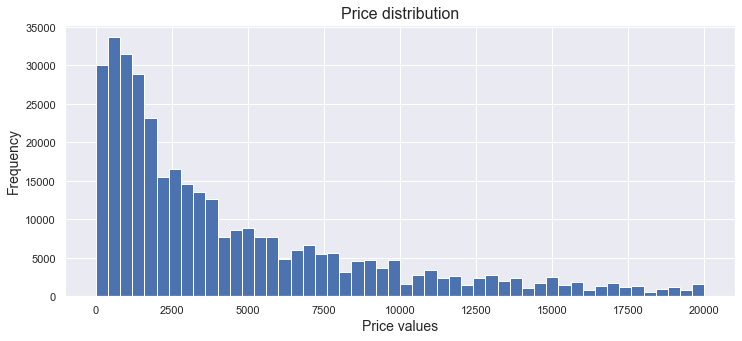

In [19]:
feature_hist(series=automobile_data['price'], 
             bins_=50, range_=(0, 20000), 
             xlabel='Price values', 
             ylabel='Frequency', 
             title='Price distribution')

In [20]:
automobile_data = automobile_data.loc[automobile_data['price'] > 700]

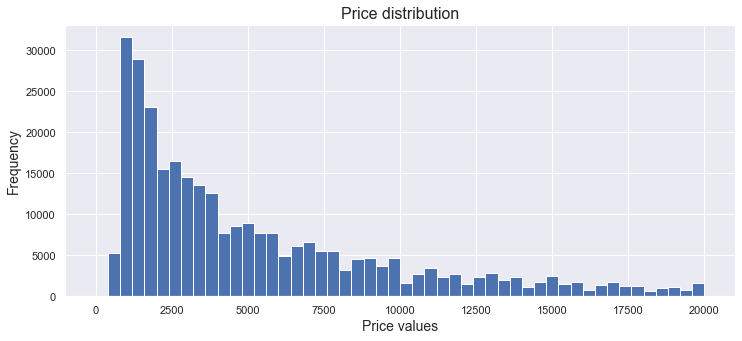

In [21]:
feature_hist(series=automobile_data['price'], 
             bins_=50, range_=(0, 20000), 
             xlabel='Price values', 
             ylabel='Frequency', 
             title='Price distribution')

**In the registration date, we will also filter out outliers. In principle, there can be no cars older than 2020. Also, taking into account the rules of the market, we will limit the age of the vehicle to no more than 50 years.**

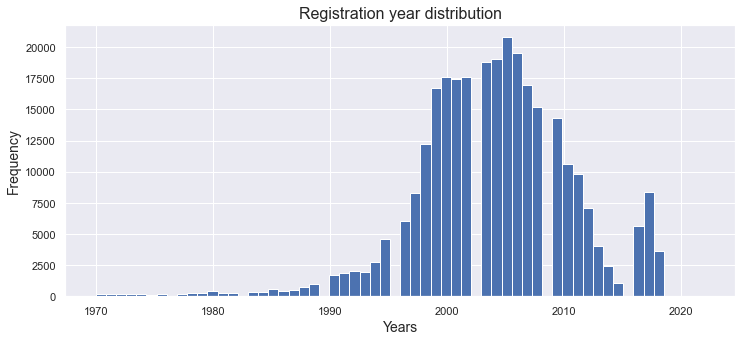

In [22]:
feature_hist(series=automobile_data['registration_year'], 
             bins_=60, range_=(1970, 2022), 
             xlabel='Years', 
             ylabel='Frequency', 
             title='Registration year distribution')

In [23]:
automobile_data = automobile_data.loc[(automobile_data['registration_year'] < 2017) & (1970 < automobile_data['registration_year'])]

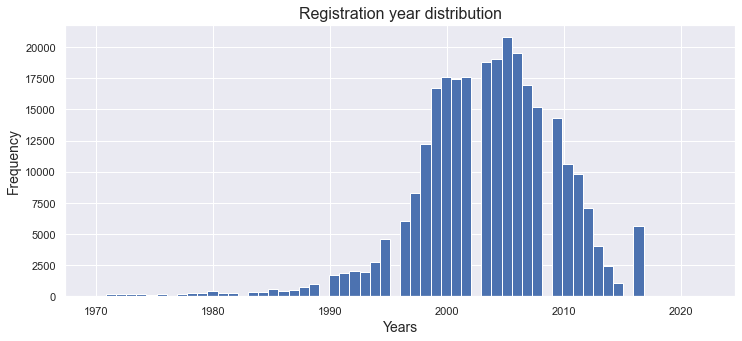

In [24]:
feature_hist(series=automobile_data['registration_year'], 
             bins_=60, range_=(1970, 2022), 
             xlabel='Years', 
             ylabel='Frequency', 
             title='Registration year distribution')

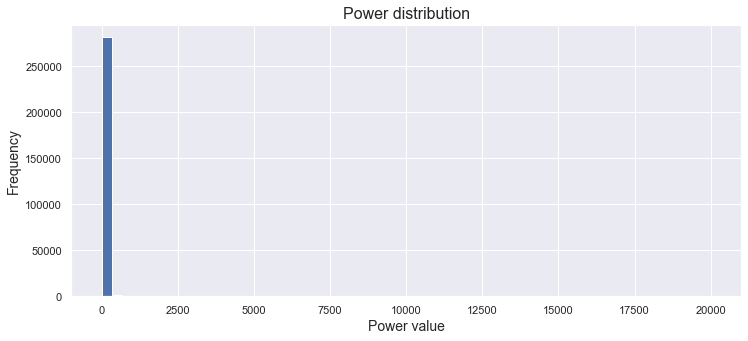

In [25]:
feature_hist(series=automobile_data['power'], 
             bins_=60, range_=(0, 20000), 
             xlabel='Power value', 
             ylabel='Frequency', 
             title='Power distribution')

**Power cannot have near-zero values**

In [26]:
automobile_data = automobile_data.loc[(automobile_data['power'] < 600) & (automobile_data['power'] > 30)]

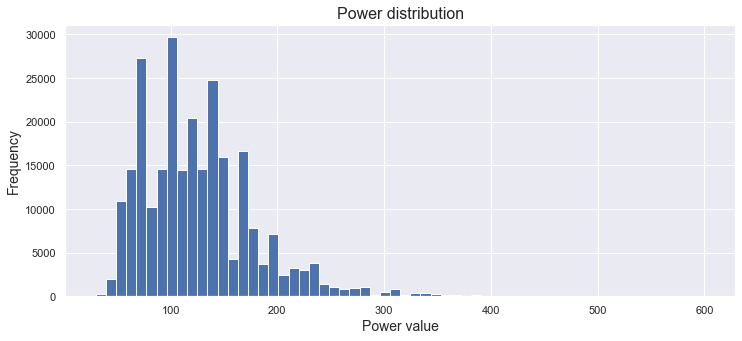

In [27]:
feature_hist(series=automobile_data['power'], 
             bins_=60, range_=(30, 600), 
             xlabel='Power value', 
             ylabel='Frequency', 
             title='Power distribution')

** Let's re-create the diagrams of distributions of numerical features: **

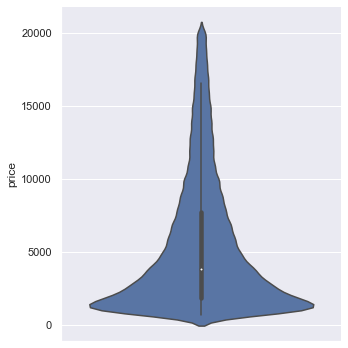

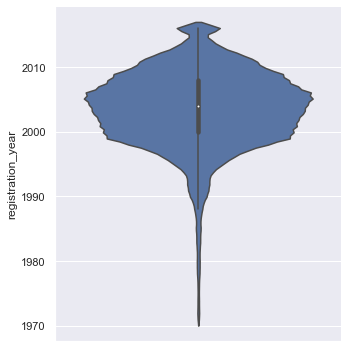

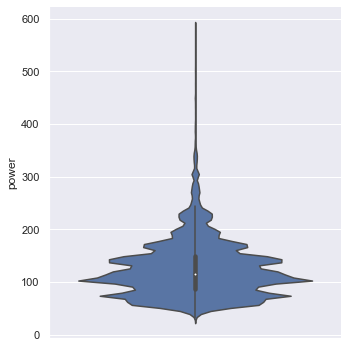

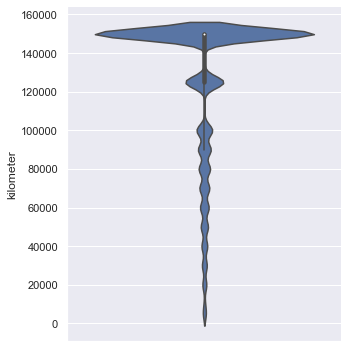

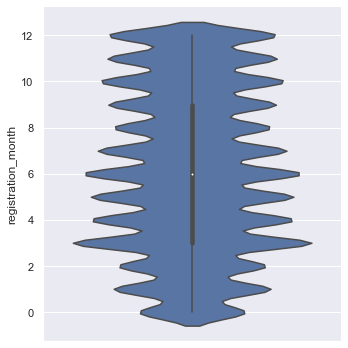

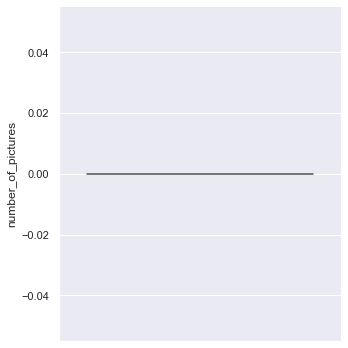

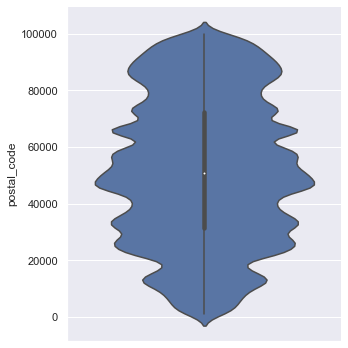

In [28]:
data_distribution(automobile_data)

Outliers and anomalous values removed✅

In [29]:
automobile_data.power.count()

260438

14% of the dataset has been removed, which is acceptable when processing data.

#### Filling the gaps

Let's compare 2 options for filling gaps.

**Option 1**. Padding with the most frequent value.

In [30]:
imputer = SimpleImputer(strategy='most_frequent')

In [31]:
automobile_data[['not_repaired', 'fuel_type','gear_box', 'vehicle_type', 'model']] = imputer.fit_transform(
    automobile_data[['not_repaired', 'fuel_type', 'gear_box', 'vehicle_type', 'model']])

**Option 2**. Filling with a constant.

In [32]:
# imputer_2 = SimpleImputer(strategy='constant',  fill_value='other')

# automobile_data_2[['not_repaired', 'fuel_type','gear_box', 'vehicle_type', 'model']] = imputer_2.fit_transform(
#     automobile_data_2[['not_repaired', 'fuel_type', 'gear_box', '  vehicle_type', 'model']])

There are three main ways to fill in the gaps of categorical features:

- delete passes
- filling with the most frequent value
- constant padding

Removing gaps can be done if they are less than 10% of the entire dataset. If there are more gaps, then removing them can adversely affect the quality of the models. In our case, this option is not suitable, because there are quite a lot of missing values. Empirically, it was found that the best option in this case would be to fill in the most frequent value.

In [33]:
display(isna_style(automobile_data))

,count_nan,%_nan
date_crawled,0,0.000000
price,0,0.000000
vehicle_type,0,0.000000
registration_year,0,0.000000
gear_box,0,0.000000
power,0,0.000000
model,0,0.000000
kilometer,0,0.000000
registration_month,0,0.000000
fuel_type,0,0.000000


In [34]:
X = automobile_data.drop(['date_crawled', 
                          'number_of_pictures', 
                          'date_created', 
                          'last_seen',                 
                          'price', 
                          'registration_month'], axis=1)
y = automobile_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=57685)

cat_features = ['vehicle_type', 'gear_box', 'model',
                'fuel_type', 'brand', 'not_repaired']

## Model Training

### Gradient Boosting Model (CatBoost Library)

#### Gradient boosting model on cross-validation with `grow_policy = SymmetricTree` 

In [35]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 150,
    'random_state': 4245,
    'learning_rate': 0.3,
    'grow_policy': 'SymmetricTree',
    'eval_metric': 'RMSE'

}

cv_data = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=4245,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 1679.476725
bestIteration = 149

Training on fold [1/5]



bestTest = 1653.671924
bestIteration = 149

Training on fold [2/5]



bestTest = 1641.831696
bestIteration = 149

Training on fold [3/5]



bestTest = 1627.793341
bestIteration = 149

Training on fold [4/5]



bestTest = 1656.506078
bestIteration = 149

Wall time: 24 s


#### Gradient boosting model on cross-validation. Selection of hyperparameters through GridSearch.

%%time
model = CatBoost()

grid = {'iterations': range(1, 101, 10),
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
       }

grid_search_result = model.grid_search(grid,                                   
                                       X=X_train, 
                                       y=y_train,
                                       cv=3,
                                       partition_random_seed=1,
                                       calc_cv_statistics=True,
                                       search_by_train_test_split=True,
                                       refit=True,
                                       verbose=False,
                                       plot=True)


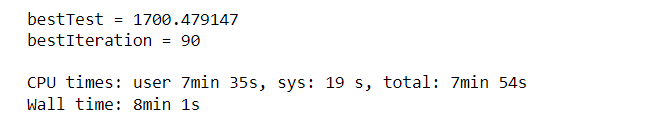

\- GridSearch gave RMSE = 1700.4. Training time 8 min.  
\- Boosting without enumeration of hyperparameters gave RMSE = 1637.2. Training time 44 sec.

**You can expand the range of GridSearch hyperparameters, add new hyperparameters, but in this case, the training time increases greatly. Considering that this library has a higher learning rate than the others, then it seems inefficient to sort through the parameters using GridSearch on other libraries.**

#### Gradient boosting model on cross-validation with parameter `grow_policy = Depthwise`

In [37]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 150,
    'random_state': 4245,
    'learning_rate': 0.3,
    'grow_policy': 'Depthwise',
    'eval_metric': 'RMSE'

}

cv_data = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=4245,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 1652.087567
bestIteration = 149

Training on fold [1/5]



bestTest = 1621.278132
bestIteration = 149

Training on fold [2/5]



bestTest = 1614.186184
bestIteration = 149

Training on fold [3/5]



bestTest = 1592.236878
bestIteration = 149

Training on fold [4/5]



bestTest = 1618.27107
bestIteration = 149

Wall time: 27.8 s


#### Gradient boosting model on cross-validation with `grow_policy = Depthwise` parameter. The number of iterations is 1000.

In [38]:
%%time
params = {
    'loss_function': 'RMSE',
    'iterations': 1000,
    'random_state': 4245,
    'learning_rate': 0.3,
    'grow_policy': 'Depthwise',
    'eval_metric': 'RMSE'

}

cv_data = cv(
    params=params,
    pool=Pool(X_train, label=y_train, cat_features=cat_features),
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=4245,
    plot=True, 
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]



bestTest = 1599.963076
bestIteration = 913

Training on fold [1/5]



bestTest = 1564.280708
bestIteration = 991

Training on fold [2/5]



bestTest = 1552.931453
bestIteration = 992

Training on fold [3/5]



bestTest = 1540.668271
bestIteration = 887

Training on fold [4/5]



bestTest = 1559.225421
bestIteration = 987

Wall time: 3min 15s


**RMSE of the best model on the CatBoost library was 1559. This library has a very good model learning rate.**

### Gradient Boosting Model (LGBM Library)

In [39]:
label = LabelEncoder()

In [40]:
for column in X_train:
    if X_train[column].dtype=='object':
        X_train[column] = label.fit_transform(X_train[column])
        X_test[column] = label.fit_transform(X_test[column])

#### Gradient boosting model on cross-validation with 100 trees

In [41]:
%%time
dftrainLGB = lightgbm.Dataset(data = X_train, label = y_train, feature_name = "auto")

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'verbose': 10,
    'n_jobs': -1
    }
    
cv_results = lightgbm.cv( 
    params,
    dftrainLGB,
    num_boost_round=100,
    nfold=5,
    metrics='rmse',
    seed=1
    )

C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.856631
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181977
[LightGBM] [Debug] init for col-wise cost 0.001832 seconds, init for row-wise cost 0.001961 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 156262, number of used features: 10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.856631
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.181977
[LightGBM] [Debug] init for col-wise cost 0.001411 seconds, init for row-wise cost 0.002152 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [

In [42]:
iterations = {'iterations': list(range(1, 101))}
cv_results.update(iterations)
cv_lgbm_result = pd.DataFrame(cv_results)
cv_lgbm_result.tail(5)

,rmse-mean,rmse-stdv,iterations
95,1691.802932,8.446874,96
96,1690.569264,8.371155,97
97,1689.670896,8.314887,98
98,1688.864568,8.323018,99
99,1687.813911,8.223294,100


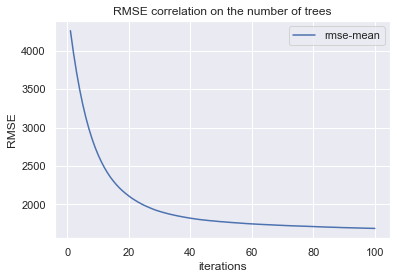

In [43]:
cv_lgbm_result.plot(x='iterations', y='rmse-mean', kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12);

**RMSE=1687.8. RMSE turned out to be much worse than the model using the CatBoost library. Quality dropped by 8%.

#### Gradient boosting model on cross-validation with the number of trees equal to 1000

In [44]:
%%time
dftrainLGB = lightgbm.Dataset(data = X_train, label = y_train, feature_name = "auto")

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'verbose': 0,
    'n_jobs': -1
    }
    
cv_results = lightgbm.cv( 
    params,
    dftrainLGB,
    num_boost_round=1000,
    nfold=5,
    metrics='rmse',
    seed=1
    )

C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [45]:
iterations = {'iterations': list(range(1, 1001))}
cv_results.update(iterations)
cv_lgbm_result = pd.DataFrame(cv_results)
cv_lgbm_result.tail(5)

,rmse-mean,rmse-stdv,iterations
995,1548.279013,9.684979,996
996,1548.264822,9.663150,997
997,1548.245303,9.633280,998
998,1548.235136,9.626381,999
999,1548.160484,9.608289,1000


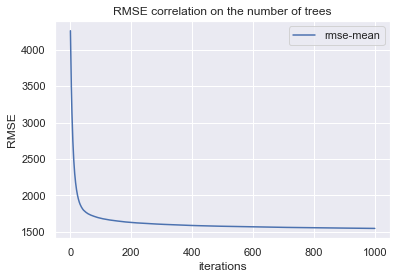

In [46]:
cv_lgbm_result.plot(x='iterations', y='rmse-mean', kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12);

**RMSE = 1548.1. With 10 times more trees, RMSE decreased by 9%. Training time increased by 80%.

#### Gradient boosting model on cross-validation with variable boosting_type = 'dart'

In [47]:
%%time
dftrainLGB = lightgbm.Dataset(data = X_train, label = y_train, feature_name = "auto")

params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'verbose': 0,
    'n_jobs': -1
    }
    
cv_results = lightgbm.cv( 
    params,
    dftrainLGB,
    num_boost_round=100,
    nfold=5,
    metrics='rmse',
    seed=1
    )

C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [48]:
iterations = {'iterations': list(range(1, 101))}
cv_results.update(iterations)
cv_lgbm_result = pd.DataFrame(cv_results)
cv_lgbm_result.tail(5)

,rmse-mean,rmse-stdv,iterations
95,2082.386161,11.369663,96
96,2040.711948,11.434993,97
97,2054.845714,11.187749,98
98,2017.136655,11.639894,99
99,1984.997022,11.926442,100


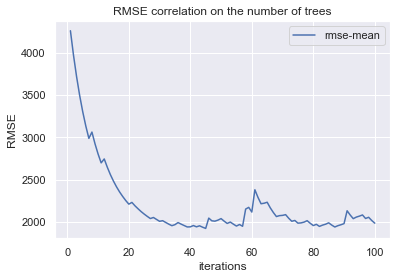

In [49]:
cv_lgbm_result.plot(x='iterations', y='rmse-mean', kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12);

Here rmse is minimal at 45 trees. Next, change the number of trees to 45.

**Changing the `boosting_type' parameter to 'dart'` did not bring good results. RMSE has increased by 436 points to 1984.9, but the learning rate has halved.**

#### Gradient boosting model on cross-validation with variable boosting_type = 'rf'

In [50]:
%%time
dftrainLGB = lightgbm.Dataset(data = X_train, label = y_train, feature_name = "auto")

params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'verbose': 0,
    'n_jobs': -1,
    'bagging_freq':1,
    'bagging_fraction' : 0.6
    }
    
cv_results = lightgbm.cv( 
    params,
    dftrainLGB,
    num_boost_round=100,
    nfold=5,
    metrics='rmse',
    seed=1

    )

C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing

In [51]:
iterations = {'iterations': list(range(1, 101))}
cv_results.update(iterations)
cv_lgbm_result = pd.DataFrame(cv_results)
cv_lgbm_result.tail(5)

,rmse-mean,rmse-stdv,iterations
95,2366.100784,12.370673,96
96,2366.112850,12.403711,97
97,2366.004389,12.462911,98
98,2366.033874,12.429419,99
99,2366.138019,12.444954,100


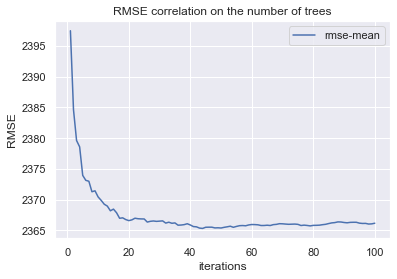

In [52]:
cv_lgbm_result.plot(x='iterations', y='rmse-mean', kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12);

**RMSE turned out to be quite large. The boosting_type = 'rf' option is not effective here.

#### Gradient boosting model. Selection of hyperparameters through GridSearchCV

In [53]:
%%time
params = {
    'boosting_type': ['gbdt'],
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100, 150, 200],
}

grid = GridSearchCV(lightgbm.LGBMRegressor(random_state=0), params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

Wall time: 6min 11s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=0),
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [50, 100, 150, 200],
                         'num_leaves': [7, 14, 21, 28, 31, 50]},
             scoring='neg_root_mean_squared_error')

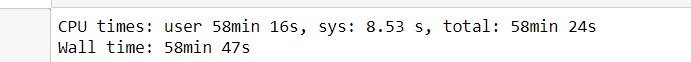

In [54]:
grid.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.3,
 'max_depth': 5,
 'n_estimators': 200,
 'num_leaves': 50}

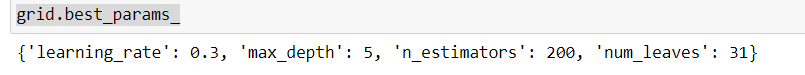

In [55]:
%%time
reg = lightgbm.Dataset(data = X_train, label = y_train, feature_name = "auto")

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'verbose': 0,
    'n_jobs': -1,
    'bagging_freq':1,
    'bagging_fraction' : 0.6,
    'learning_rate': 0.3,
    'max_depth': 5,
    'num_leaves':31
    }
    
cv_results = lightgbm.cv( 
    params,
    dftrainLGB,
    num_boost_round=200,
    nfold=5,
    metrics='rmse',
    seed=1

    )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Vadim\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002780 seconds.
You can set `force_row_wise=true` to remove t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [56]:
iterations = {'iterations': list(range(1, 201))}
cv_results.update(iterations)
cv_lgbm_result = pd.DataFrame(cv_results)
cv_lgbm_result.tail(5)

,rmse-mean,rmse-stdv,iterations
195,1642.528217,11.139311,196
196,1642.448504,11.065735,197
197,1642.428827,11.285347,198
198,1642.373144,11.604657,199
199,1641.948066,11.642344,200


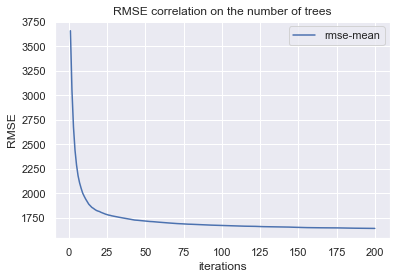

In [57]:
cv_lgbm_result.plot(x='iterations', y='rmse-mean', kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=12)
plt.ylabel('RMSE', fontsize=12);

The selection of parameters on GridSearchCV did not give a significant improvement in the metric.

### Gradient boosting model on cross-validation (XGBoost library)

In [58]:
%%time
dftrainXGB = xgb.DMatrix(data = X_train, label = y_train)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'verbosity': 1,
    'n_jobs': -1,
    'learning_rate': 0.3
    }
    
cv_xgb_results = xgb.cv( 
    params,
    dftrainXGB,
    num_boost_round=100,
    nfold=5,
    metrics='rmse',
    seed=1
    )

Wall time: 15.1 s


In [59]:
iterations = pd.DataFrame({'iterations': list(range(1, 101))})
cv_xgb_results = cv_xgb_results.join(iterations)
cv_xgb_result = pd.DataFrame(cv_xgb_results)
cv_xgb_result.tail(5)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,iterations
95,1493.372391,5.583074,1612.868493,12.666166,96
96,1492.062905,5.680917,1612.512283,12.280845,97
97,1490.455268,5.707419,1611.621781,11.934516,98
98,1488.980952,5.673315,1611.263053,11.800134,99
99,1487.613011,5.986733,1610.790160,11.941248,100


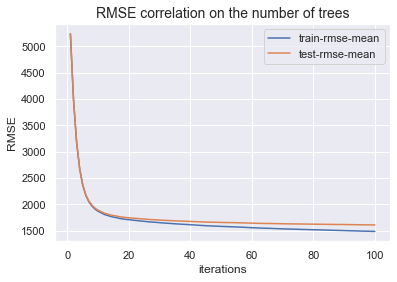

In [60]:
cv_xgb_result.plot(x='iterations', y=['train-rmse-mean', 'test-rmse-mean'], kind='line').set_title(
    'RMSE correlation on the number of trees', fontsize=14)
plt.ylabel('RMSE', fontsize=12);

**The model gave a good RMSE metric compared to previous models: 1693.2. The learning rate is average.**

#### Gradient boosting model. Selection of hyperparameters through GridSearchCV

In [61]:
%%time
params = {
    'booster': ['gbtree'],
    'objective': ['reg:squarederror'],
    'n_jobs': [-1],
    'max_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [1, 3, 5],
    'n_estimators': [50, 100,  150, 200],
}

grid = GridSearchCV(xgb.XGBRegressor(random_state=0), params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

Wall time: 31min 56s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'booster': ['gbtree'],
                         'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5],
                         'max_leaves': [7, 14, 21, 28, 31, 50],
                         'n_estimators': [50, 100, 150, 200], 'n_jobs': [-1],
                         'objective': ['reg:squarederror']},
             scoring='neg_root_mean_squared_error')

In [62]:
grid.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.3,
 'max_depth': 5,
 'max_leaves': 7,
 'n_estimators': 200,
 'n_jobs': -1,
 'objective': 'reg:squarederror'}

In [63]:
print('RMSE:', mean_squared_error(y_test, grid.predict(X_test)) ** 0.5)

RMSE: 1697.026424748143


### Linear regression model on cross-validation

In [64]:
%%time
model_lr = LinearRegression(n_jobs=-1)
score = abs(np.mean(cross_val_score(model_lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')))
print("RMSE лучшей модели логистической регрессии:", score)

RMSE лучшей модели логистической регрессии: 2899.4528494145225
Wall time: 287 ms


### Random forest model on cross-validation

In [65]:
%%time
best_model_rf = None
best_cv_score = 20000
best_estimators = 0
for n in range(1, 101, 10):
    model_rf = RandomForestRegressor(n_estimators=n, max_depth= 100, random_state=12345, n_jobs=-1)
    cv_score = abs(np.mean(cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')))
    if cv_score < best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_estimators = n 
print("RMSE лучшей модели случайного леса:", cv_score)
print("Количество деревьев:", n) 

RMSE лучшей модели случайного леса: 1588.093431882849
Количество деревьев: 91
Wall time: 2min 37s


In [66]:
%%time
best_model_rf = None
best_cv_score = 20000
best_depth = 0
for depth in range(1, 101, 10):
    model_rf = RandomForestRegressor(n_estimators=91, max_depth= depth, random_state=12345, n_jobs=-1)
    cv_score = abs(np.mean(cross_val_score(model_rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))) 
    if cv_score < best_cv_score:
        best_model_rf = model_rf
        best_cv_score = cv_score 
        best_depth = depth 
print("RMSE лучшей модели случайного леса:", cv_score)
print("Глубина лучшей модели:", best_depth)

RMSE лучшей модели случайного леса: 1588.093431882849
Глубина лучшей модели: 21
Wall time: 3min 58s


### Evaluation of the quality of the best model on the test set

We will choose the two most efficient models that have shown themselves well at the stage of selecting hyperparameters.

In [67]:
%%time
ctb = CatBoostRegressor(loss_function='RMSE',
                        iterations=1000,
                        random_state=4245,
                        learning_rate=0.3,
                        grow_policy='Depthwise',
                        verbose=1)

ctb.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=cat_features)

0:	learn: 3629.4654732	test: 3648.3094351	best: 3648.3094351 (0)	total: 48.1ms	remaining: 48.1s
1:	learn: 3008.6486683	test: 3028.0038323	best: 3028.0038323 (1)	total: 88.6ms	remaining: 44.2s
2:	learn: 2597.5931834	test: 2628.8793968	best: 2628.8793968 (2)	total: 133ms	remaining: 44.1s
3:	learn: 2334.4437087	test: 2389.9947128	best: 2389.9947128 (3)	total: 169ms	remaining: 42s
4:	learn: 2167.0250993	test: 2247.1022797	best: 2247.1022797 (4)	total: 205ms	remaining: 40.7s
5:	learn: 2056.9942363	test: 2155.3647835	best: 2155.3647835 (5)	total: 241ms	remaining: 39.9s
6:	learn: 1977.9726876	test: 2074.6153825	best: 2074.6153825 (6)	total: 277ms	remaining: 39.3s
7:	learn: 1928.9984460	test: 2041.3015303	best: 2041.3015303 (7)	total: 312ms	remaining: 38.7s
8:	learn: 1887.9278722	test: 2001.3951607	best: 2001.3951607 (8)	total: 347ms	remaining: 38.2s
9:	learn: 1861.5073723	test: 1976.9763567	best: 1976.9763567 (9)	total: 380ms	remaining: 37.6s
10:	learn: 1828.8335571	test: 1957.0763956	best: 1

90:	learn: 1591.6956576	test: 1823.4644710	best: 1823.4644710 (90)	total: 3.13s	remaining: 31.3s
91:	learn: 1589.3145817	test: 1821.4964071	best: 1821.4964071 (91)	total: 3.16s	remaining: 31.2s
92:	learn: 1587.6680327	test: 1821.1681592	best: 1821.1681592 (92)	total: 3.2s	remaining: 31.2s
93:	learn: 1587.2227213	test: 1821.1843138	best: 1821.1681592 (92)	total: 3.23s	remaining: 31.1s
94:	learn: 1586.2424748	test: 1821.8241655	best: 1821.1681592 (92)	total: 3.27s	remaining: 31.1s
95:	learn: 1583.6386590	test: 1820.7759457	best: 1820.7759457 (95)	total: 3.3s	remaining: 31.1s
96:	learn: 1583.2376018	test: 1820.6026629	best: 1820.6026629 (96)	total: 3.33s	remaining: 31s
97:	learn: 1582.2115455	test: 1820.4661346	best: 1820.4661346 (97)	total: 3.37s	remaining: 31s
98:	learn: 1580.9418285	test: 1818.1573289	best: 1818.1573289 (98)	total: 3.4s	remaining: 31s
99:	learn: 1579.4281310	test: 1818.1773218	best: 1818.1573289 (98)	total: 3.43s	remaining: 30.9s
100:	learn: 1578.8038329	test: 1818.127

174:	learn: 1506.9265192	test: 1799.7943022	best: 1799.7943022 (174)	total: 5.93s	remaining: 28s
175:	learn: 1506.6726619	test: 1799.9455045	best: 1799.7943022 (174)	total: 5.96s	remaining: 27.9s
176:	learn: 1506.1515931	test: 1799.4657439	best: 1799.4657439 (176)	total: 5.99s	remaining: 27.9s
177:	learn: 1504.9311503	test: 1799.0687785	best: 1799.0687785 (177)	total: 6.03s	remaining: 27.8s
178:	learn: 1504.3752873	test: 1799.2002525	best: 1799.0687785 (177)	total: 6.06s	remaining: 27.8s
179:	learn: 1504.1934299	test: 1799.1783404	best: 1799.0687785 (177)	total: 6.09s	remaining: 27.7s
180:	learn: 1503.9443190	test: 1799.2592800	best: 1799.0687785 (177)	total: 6.12s	remaining: 27.7s
181:	learn: 1503.2527566	test: 1798.4636934	best: 1798.4636934 (181)	total: 6.16s	remaining: 27.7s
182:	learn: 1502.7245743	test: 1798.5930624	best: 1798.4636934 (181)	total: 6.19s	remaining: 27.6s
183:	learn: 1501.8498640	test: 1802.1188616	best: 1798.4636934 (181)	total: 6.22s	remaining: 27.6s
184:	learn: 

262:	learn: 1457.9210570	test: 1794.6904879	best: 1794.3736735 (247)	total: 8.8s	remaining: 24.7s
263:	learn: 1457.3611464	test: 1793.7147958	best: 1793.7147958 (263)	total: 8.83s	remaining: 24.6s
264:	learn: 1456.7077988	test: 1793.7611389	best: 1793.7147958 (263)	total: 8.87s	remaining: 24.6s
265:	learn: 1455.9120949	test: 1793.3870429	best: 1793.3870429 (265)	total: 8.91s	remaining: 24.6s
266:	learn: 1455.1364608	test: 1792.9012064	best: 1792.9012064 (266)	total: 8.94s	remaining: 24.6s
267:	learn: 1454.8317899	test: 1792.6496029	best: 1792.6496029 (267)	total: 8.97s	remaining: 24.5s
268:	learn: 1454.3534479	test: 1792.9466710	best: 1792.6496029 (267)	total: 9.01s	remaining: 24.5s
269:	learn: 1453.8932597	test: 1792.4000532	best: 1792.4000532 (269)	total: 9.05s	remaining: 24.5s
270:	learn: 1453.1151824	test: 1792.0198343	best: 1792.0198343 (270)	total: 9.09s	remaining: 24.5s
271:	learn: 1452.9023458	test: 1792.3566593	best: 1792.0198343 (270)	total: 9.12s	remaining: 24.4s
272:	learn:

348:	learn: 1418.9855245	test: 1782.1245935	best: 1782.1245935 (348)	total: 11.6s	remaining: 21.7s
349:	learn: 1418.6540527	test: 1782.0796382	best: 1782.0796382 (349)	total: 11.7s	remaining: 21.6s
350:	learn: 1418.3308432	test: 1781.8998876	best: 1781.8998876 (350)	total: 11.7s	remaining: 21.6s
351:	learn: 1418.1320002	test: 1781.9486849	best: 1781.8998876 (350)	total: 11.7s	remaining: 21.6s
352:	learn: 1417.4986640	test: 1782.0441532	best: 1781.8998876 (350)	total: 11.7s	remaining: 21.5s
353:	learn: 1417.1640972	test: 1779.0262976	best: 1779.0262976 (353)	total: 11.8s	remaining: 21.5s
354:	learn: 1416.9943220	test: 1779.1166793	best: 1779.0262976 (353)	total: 11.8s	remaining: 21.5s
355:	learn: 1416.7182528	test: 1779.0194705	best: 1779.0194705 (355)	total: 11.8s	remaining: 21.4s
356:	learn: 1416.4741582	test: 1778.4078058	best: 1778.4078058 (356)	total: 11.9s	remaining: 21.4s
357:	learn: 1415.8221115	test: 1778.3835049	best: 1778.3835049 (357)	total: 11.9s	remaining: 21.4s
358:	learn

437:	learn: 1384.9664604	test: 1778.2148089	best: 1777.0728843 (372)	total: 14.5s	remaining: 18.6s
438:	learn: 1384.8671235	test: 1778.1334910	best: 1777.0728843 (372)	total: 14.5s	remaining: 18.6s
439:	learn: 1384.6081913	test: 1778.3185802	best: 1777.0728843 (372)	total: 14.6s	remaining: 18.5s
440:	learn: 1384.2161023	test: 1777.9766885	best: 1777.0728843 (372)	total: 14.6s	remaining: 18.5s
441:	learn: 1383.9301574	test: 1778.0952949	best: 1777.0728843 (372)	total: 14.6s	remaining: 18.5s
442:	learn: 1383.3341682	test: 1777.9744638	best: 1777.0728843 (372)	total: 14.7s	remaining: 18.4s
443:	learn: 1383.0405949	test: 1778.2045984	best: 1777.0728843 (372)	total: 14.7s	remaining: 18.4s
444:	learn: 1382.9543538	test: 1778.2102996	best: 1777.0728843 (372)	total: 14.7s	remaining: 18.4s
445:	learn: 1382.4250893	test: 1778.3259576	best: 1777.0728843 (372)	total: 14.8s	remaining: 18.3s
446:	learn: 1382.3738943	test: 1778.3420398	best: 1777.0728843 (372)	total: 14.8s	remaining: 18.3s
447:	learn

523:	learn: 1356.0919200	test: 1777.5869469	best: 1776.1674268 (505)	total: 17.3s	remaining: 15.7s
524:	learn: 1355.6886961	test: 1777.5100898	best: 1776.1674268 (505)	total: 17.4s	remaining: 15.7s
525:	learn: 1355.2707356	test: 1777.4078008	best: 1776.1674268 (505)	total: 17.4s	remaining: 15.7s
526:	learn: 1355.1548537	test: 1777.5518878	best: 1776.1674268 (505)	total: 17.4s	remaining: 15.6s
527:	learn: 1355.0280995	test: 1777.5732064	best: 1776.1674268 (505)	total: 17.5s	remaining: 15.6s
528:	learn: 1354.8137372	test: 1777.5871349	best: 1776.1674268 (505)	total: 17.5s	remaining: 15.6s
529:	learn: 1354.4613102	test: 1777.4801042	best: 1776.1674268 (505)	total: 17.5s	remaining: 15.5s
530:	learn: 1354.2591701	test: 1777.5399528	best: 1776.1674268 (505)	total: 17.5s	remaining: 15.5s
531:	learn: 1354.1492002	test: 1777.5416772	best: 1776.1674268 (505)	total: 17.6s	remaining: 15.5s
532:	learn: 1353.7376017	test: 1777.6719118	best: 1776.1674268 (505)	total: 17.6s	remaining: 15.4s
533:	learn

609:	learn: 1332.4442636	test: 1778.7440273	best: 1776.1674268 (505)	total: 20.1s	remaining: 12.8s
610:	learn: 1331.9811881	test: 1778.6443413	best: 1776.1674268 (505)	total: 20.1s	remaining: 12.8s
611:	learn: 1331.9396264	test: 1778.6281427	best: 1776.1674268 (505)	total: 20.2s	remaining: 12.8s
612:	learn: 1331.8680829	test: 1778.5659201	best: 1776.1674268 (505)	total: 20.2s	remaining: 12.7s
613:	learn: 1331.7324902	test: 1778.5320091	best: 1776.1674268 (505)	total: 20.2s	remaining: 12.7s
614:	learn: 1331.5781961	test: 1778.5959107	best: 1776.1674268 (505)	total: 20.3s	remaining: 12.7s
615:	learn: 1331.3941163	test: 1778.1959814	best: 1776.1674268 (505)	total: 20.3s	remaining: 12.6s
616:	learn: 1331.2859576	test: 1778.1885540	best: 1776.1674268 (505)	total: 20.3s	remaining: 12.6s
617:	learn: 1331.1183048	test: 1778.1832191	best: 1776.1674268 (505)	total: 20.4s	remaining: 12.6s
618:	learn: 1330.9679786	test: 1778.1794828	best: 1776.1674268 (505)	total: 20.4s	remaining: 12.5s
619:	learn

697:	learn: 1314.9370474	test: 1776.5739989	best: 1776.1674268 (505)	total: 22.9s	remaining: 9.91s
698:	learn: 1314.7484731	test: 1776.6325587	best: 1776.1674268 (505)	total: 22.9s	remaining: 9.88s
699:	learn: 1314.6480817	test: 1776.7186791	best: 1776.1674268 (505)	total: 23s	remaining: 9.85s
700:	learn: 1314.4435712	test: 1776.6990605	best: 1776.1674268 (505)	total: 23s	remaining: 9.81s
701:	learn: 1314.3451385	test: 1776.7204334	best: 1776.1674268 (505)	total: 23s	remaining: 9.78s
702:	learn: 1314.2169291	test: 1776.9246924	best: 1776.1674268 (505)	total: 23.1s	remaining: 9.75s
703:	learn: 1313.6357285	test: 1776.7635208	best: 1776.1674268 (505)	total: 23.1s	remaining: 9.72s
704:	learn: 1313.2014142	test: 1776.6756006	best: 1776.1674268 (505)	total: 23.1s	remaining: 9.69s
705:	learn: 1313.1088271	test: 1776.7215983	best: 1776.1674268 (505)	total: 23.2s	remaining: 9.65s
706:	learn: 1312.7545931	test: 1777.4000795	best: 1776.1674268 (505)	total: 23.2s	remaining: 9.62s
707:	learn: 1312

784:	learn: 1294.4816833	test: 1779.5938182	best: 1776.1674268 (505)	total: 25.8s	remaining: 7.05s
785:	learn: 1294.4491064	test: 1779.5858248	best: 1776.1674268 (505)	total: 25.8s	remaining: 7.02s
786:	learn: 1294.3559107	test: 1779.7314020	best: 1776.1674268 (505)	total: 25.8s	remaining: 6.99s
787:	learn: 1294.2115908	test: 1779.7270974	best: 1776.1674268 (505)	total: 25.8s	remaining: 6.95s
788:	learn: 1294.1160594	test: 1780.2324476	best: 1776.1674268 (505)	total: 25.9s	remaining: 6.92s
789:	learn: 1294.0465772	test: 1780.1524939	best: 1776.1674268 (505)	total: 25.9s	remaining: 6.89s
790:	learn: 1293.9339469	test: 1780.2298865	best: 1776.1674268 (505)	total: 25.9s	remaining: 6.85s
791:	learn: 1293.6431742	test: 1780.2822710	best: 1776.1674268 (505)	total: 26s	remaining: 6.82s
792:	learn: 1293.4789020	test: 1779.9422588	best: 1776.1674268 (505)	total: 26s	remaining: 6.79s
793:	learn: 1293.1996943	test: 1779.9559405	best: 1776.1674268 (505)	total: 26s	remaining: 6.75s
794:	learn: 1293

873:	learn: 1277.2000199	test: 1780.5675924	best: 1776.1674268 (505)	total: 28.7s	remaining: 4.13s
874:	learn: 1277.0997872	test: 1780.3366991	best: 1776.1674268 (505)	total: 28.7s	remaining: 4.1s
875:	learn: 1276.9031924	test: 1780.1152472	best: 1776.1674268 (505)	total: 28.7s	remaining: 4.07s
876:	learn: 1276.8236711	test: 1780.2993398	best: 1776.1674268 (505)	total: 28.8s	remaining: 4.03s
877:	learn: 1276.5513233	test: 1780.3040840	best: 1776.1674268 (505)	total: 28.8s	remaining: 4s
878:	learn: 1276.4261478	test: 1780.2108219	best: 1776.1674268 (505)	total: 28.8s	remaining: 3.97s
879:	learn: 1276.0058974	test: 1780.2715457	best: 1776.1674268 (505)	total: 28.9s	remaining: 3.94s
880:	learn: 1275.9458716	test: 1780.2913918	best: 1776.1674268 (505)	total: 28.9s	remaining: 3.9s
881:	learn: 1275.6888036	test: 1780.3433232	best: 1776.1674268 (505)	total: 28.9s	remaining: 3.87s
882:	learn: 1275.5553119	test: 1780.3423791	best: 1776.1674268 (505)	total: 29s	remaining: 3.84s
883:	learn: 1275.

962:	learn: 1260.8982978	test: 1784.8587633	best: 1776.1674268 (505)	total: 31.6s	remaining: 1.21s
963:	learn: 1260.8188680	test: 1784.7850674	best: 1776.1674268 (505)	total: 31.6s	remaining: 1.18s
964:	learn: 1260.5877096	test: 1784.7704786	best: 1776.1674268 (505)	total: 31.6s	remaining: 1.15s
965:	learn: 1260.1797997	test: 1784.7016513	best: 1776.1674268 (505)	total: 31.6s	remaining: 1.11s
966:	learn: 1260.0666193	test: 1784.5766214	best: 1776.1674268 (505)	total: 31.7s	remaining: 1.08s
967:	learn: 1259.9754121	test: 1784.5210142	best: 1776.1674268 (505)	total: 31.7s	remaining: 1.05s
968:	learn: 1259.6859712	test: 1784.5415027	best: 1776.1674268 (505)	total: 31.7s	remaining: 1.01s
969:	learn: 1259.5617483	test: 1784.5435779	best: 1776.1674268 (505)	total: 31.8s	remaining: 983ms
970:	learn: 1259.4190938	test: 1784.6929685	best: 1776.1674268 (505)	total: 31.8s	remaining: 950ms
971:	learn: 1259.1698054	test: 1784.7872551	best: 1776.1674268 (505)	total: 31.8s	remaining: 917ms
972:	learn

In [68]:
%%time
model_rf = RandomForestRegressor(n_estimators=91, max_depth= 21, random_state=12345, n_jobs=-1)
model_rf.fit(X_train, y_train)
pred_y = model_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, pred_y)
print('RMSE:', rf_mse**0.5)


RMSE: 1616.954335377544
Wall time: 5.49 s


**The best result was received on the Random Forest. RMSE = 1616.9, which is better than many models in the validation sample.**

## General conclusion

During the study, 3 algorithms of the gradient boosting library were tested: CatBoost, LightGBM and XGBoost. Several models with different hyperparameters were built on each library. Then models were created on several simple algorithms such as: linear regression and random forest.

CatBoost proved to be the fastest library. For the same reason, GridSearch was implemented on CatBoost with enumeration of hyperparameters. However, the results on GridSearch did not outperform those on other models.

With the same hyperparameters, the model was trained for the longest time on the XGBoost library. RMSE turned out to be close to the model implemented on the CatBoost library.

Among the gradient boosting models, the best model was the XGBoost library model with RMSE = 1693.2 and a training time of 2.08 min.

**Among all the models in terms of prediction speed, prediction quality and training time, the best model was random forest with RMSE = 1616.9 and training time 4.95 s.**
